In [56]:
#pip install --upgrade threadpoolctl

# only need to run if Kmeans does not work

  Obtaining dependency information for threadpoolctl from https://files.pythonhosted.org/packages/1e/84/ccd9b08653022b7785b6e3ee070ffb2825841e0dc119be22f0840b2b35cb/threadpoolctl-3.4.0-py3-none-any.whl.metadata
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import mapclassify
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import libpysal 
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand
import numpy as np
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt
from splot.libpysal import plot_spatial_weights
import seaborn as sns
import numpy as np
import pandas as pd
import pysal as ps
from sklearn import cluster
from sklearn.preprocessing import scale
from spopt.region.maxp import MaxPHeuristic
from sklearn.cluster import KMeans


sns.set(style="whitegrid")

In [27]:
df=pd.read_csv('south/south.csv')

In [28]:
df.head(5)

NAME     STATE_NAME  STATE_FIPS  CNTY_FIPS   FIPS  STFIPS  COFIPS  \
0     Hancock  West Virginia          54         29  54029      54      29   
1      Brooke  West Virginia          54          9  54009      54       9   
2        Ohio  West Virginia          54         69  54069      54      69   
3    Marshall  West Virginia          54         51  54051      54      51   
4  New Castle       Delaware          10          3  10003      10       3   

   FIPSNO  SOUTH      HR60  ...      BLK80      BLK90      GI59      GI69  \
0   54029      1  1.682864  ...   2.560740   2.557262  0.223645  0.295377   
1   54009      1  4.607233  ...   0.796992   0.748370  0.220407  0.318453   
2   54069      1  0.974132  ...   3.463161   3.310334  0.272398  0.358454   
3   54051      1  0.876248  ...   0.593636   0.546097  0.227647  0.319580   
4   10003      1  4.228385  ...  15.100160  16.480294  0.256106  0.329678   

       GI79      GI89       FH60  FH70       FH80       FH90  
0  0.332251  0.363934   9.981297   7.8   9.785797  12.604552  
1  0.314165  0.350569  10.929337   8.0  10.214990  11.242293  
2  0.376963  0.390534  15.621643  12.9  14.716681  17.574021  
3  0.320953  0.377346  11.962834   8.8   8.803253  13.564159  
4  0.365830  0.332703  12.035714  10.7  15.169480  16.380903  

[5 rows x 69 columns]

In [5]:
#renaming the column for ease - data pre processing

df.rename(columns={'MFIL59': 'MFIL60', 'MFIL69': 'MFIL70', 'MFIL79': 'MFIL80', 'MFIL89': 'MFIL90',
                   'FP59': 'FP60', 'FP69': 'FP70', 'FP79': 'FP80', 'FP89': 'FP90',
                  'GI59': 'GI60', 'GI69': 'GI70', 'GI79': 'GI80', 'GI89': 'GI90'}, inplace=True)

In [6]:
missing_values = df.isnull().sum()

# Print the count of missing values for each column
print("Missing Values:")
print(missing_values)


Missing Values:
NAME          0
STATE_NAME    0
STATE_FIPS    0
CNTY_FIPS     0
FIPS          0
             ..
GI90          0
FH60          0
FH70          0
FH80          0
FH90          0
Length: 69, dtype: int64


In [29]:
# Load the shapefile containing county boundaries
#renaming columns for ease of analysis.
shapefile_path = "south/south.shp"
gdf = gpd.read_file(shapefile_path)
gdf.rename(columns={'MFIL59': 'MFIL60', 'MFIL69': 'MFIL70', 'MFIL79': 'MFIL80', 'MFIL89': 'MFIL90',
                   'FP59': 'FP60', 'FP69': 'FP70', 'FP79': 'FP80', 'FP89': 'FP90',
                  'GI59': 'GI60', 'GI69': 'GI70', 'GI79': 'GI80', 'GI89': 'GI90'}, inplace=True)

In [31]:
gdf.head(5)

NAME     STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  STFIPS  COFIPS  \
0     Hancock  West Virginia         54       029  54029      54      29   
1      Brooke  West Virginia         54       009  54009      54       9   
2        Ohio  West Virginia         54       069  54069      54      69   
3    Marshall  West Virginia         54       051  54051      54      51   
4  New Castle       Delaware         10       003  10003      10       3   

   FIPSNO  SOUTH      HR60  ...      BLK90      GI60      GI70      GI80  \
0   54029      1  1.682864  ...   2.557262  0.223645  0.295377  0.332251   
1   54009      1  4.607233  ...   0.748370  0.220407  0.318453  0.314165   
2   54069      1  0.974132  ...   3.310334  0.272398  0.358454  0.376963   
3   54051      1  0.876248  ...   0.546097  0.227647  0.319580  0.320953   
4   10003      1  4.228385  ...  16.480294  0.256106  0.329678  0.365830   

       GI90       FH60  FH70       FH80       FH90  \
0  0.363934   9.981297   7.8   9.785797  12.604552   
1  0.350569  10.929337   8.0  10.214990  11.242293   
2  0.390534  15.621643  12.9  14.716681  17.574021   
3  0.377346  11.962834   8.8   8.803253  13.564159   
4  0.332703  12.035714  10.7  15.169480  16.380903   

                                            geometry  
0  POLYGON ((-80.62805 40.39816, -80.60204 40.480...  
1  POLYGON ((-80.52625 40.16245, -80.58760 40.175...  
2  POLYGON ((-80.52517 40.02275, -80.73843 40.035...  
3  POLYGON ((-80.52447 39.72113, -80.83248 39.718...  
4  POLYGON ((-75.77270 39.38301, -75.79144 39.723...  

[5 rows x 70 columns]

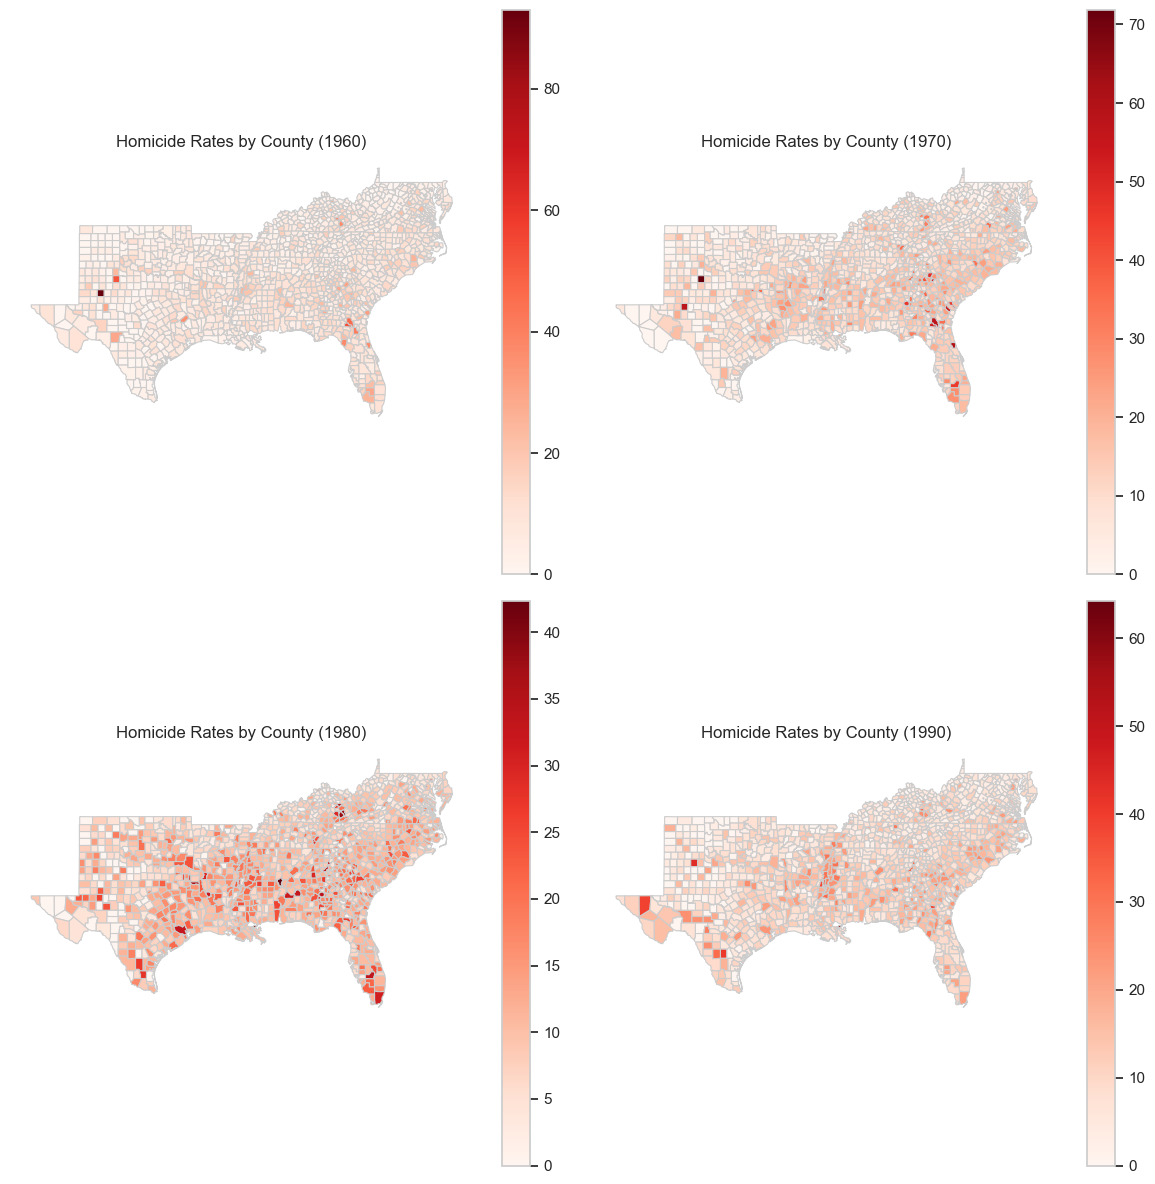

In [9]:
#Basic plot to understand trend and verify future analysis

# Increase in homicide rates in general in 1980s
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Define the years
years = [1960, 1970, 1980, 1990]

# Loop through each year and corresponding subplot
for i, year in enumerate(years):
    # Get the corresponding column name for the homicide rate
    hr_column = 'HR' + str(year)[-2:]
    
    # Plot the choropleth map for the current year
    gdf.plot(column=hr_column, cmap='Reds', linewidth=0.8, ax=axs[i//2, i%2], edgecolor='0.8', legend=True)
    axs[i//2, i%2].set_title(f'Homicide Rates by County ({year})')
    axs[i//2, i%2].axis('off')

plt.tight_layout()
plt.show()

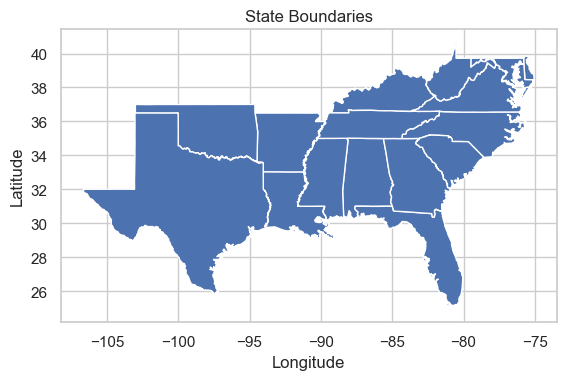

In [10]:
state_boundaries = gdf.dissolve(by='STATE_NAME')

# Plot the dissolved state boundaries
state_boundaries.plot()
plt.title('State Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

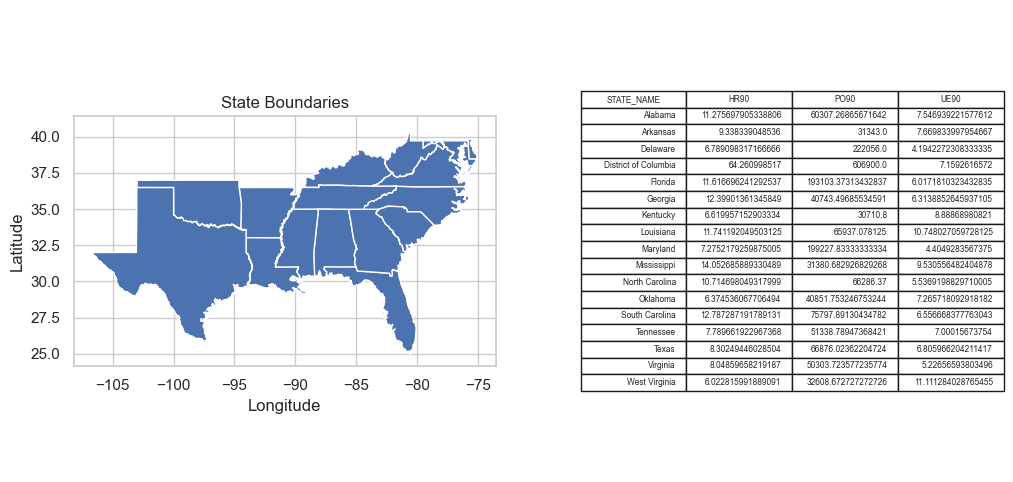

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
state_stats = gdf.groupby('STATE_NAME')[['HR90', 'PO90', 'UE90']].mean().reset_index()
# Plot state boundaries
state_boundaries.plot(ax=ax[0])
ax[0].set_title('State Boundaries')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Plot the table of mean values
ax[1].axis('off')  # Turn off axis
ax[1].table(cellText=state_stats.values, colLabels=state_stats.columns, loc='center')

plt.show()

In [12]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# higher moran means that for that code, being closer to a state with a higher HR meant a higher HR for surrounding state

from libpysal.weights import Queen
from esda.moran import Moran
# Create spatial weights matrix using Queen's contiguity
hr_columns = ['HR60', 'HR70', 'HR80', 'HR90']
years = ['1960', '1970', '1980', '1990']

homicide_rates = df[hr_columns]
w = Queen.from_dataframe(gdf)

# Compute Moran's I for each year
moran_results = {}
for i, year in enumerate(years):
    moran = Moran(homicide_rates[hr_columns[i]], w)
    moran_results[year] = moran.I

# Print Moran's I for each year
print("Moran's I for each year:")
for year, moran_i in moran_results.items():
    print(f"Year {year}: Moran's I = {moran_i}")

C:\Users\anany\AppData\Local\Temp\ipykernel_13720\3908849631.py:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


Moran's I for each year:
Year 1960: Moran's I = 0.21586235398200965
Year 1970: Moran's I = 0.26215915604907536
Year 1980: Moran's I = 0.2521152652175865
Year 1990: Moran's I = 0.2569933829094783


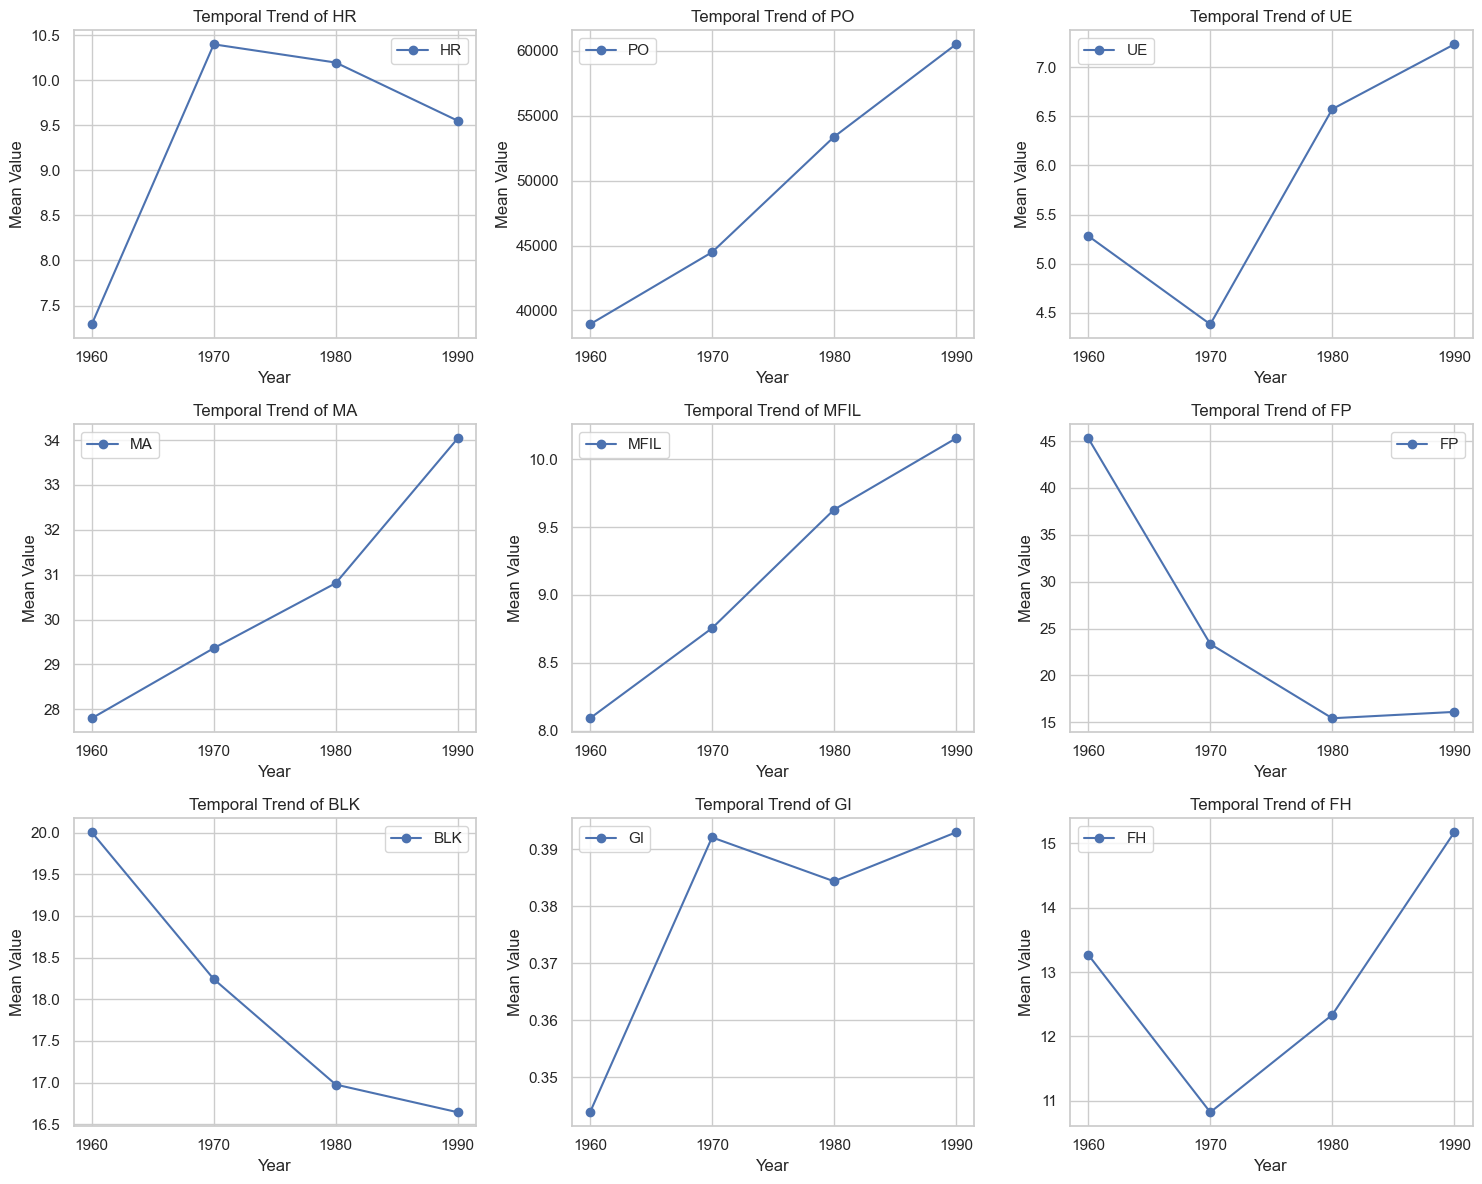

In [14]:
import math
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
years = ['1960', '1970', '1980', '1990']
variables_of_interest = ['HR', 'PO', 'UE', 'MA', 'MFIL', 'FP', 'BLK', 'GI', 'FH']

# Flatten the axes array to facilitate indexing
axes = axes.flatten()

# Plot each variable in its respective subplot
for i, variable in enumerate(variables_of_interest):
    ax = axes[i]  # Select the current subplot
    
    variable_columns = [f'{variable}{year[-2:]}' for year in years]
    
    variable_data = df[variable_columns]
    
    # Plot the temporal trend
    ax.plot(years, variable_data.mean(), marker='o', label=variable)
    
    # Add labels and legend
    ax.set_title(f'Temporal Trend of {variable}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean Value')
    ax.legend()
    ax.grid(True)
    ax.set_xticks(years)  # Ensure years are displayed as x-axis ticks

plt.tight_layout()

plt.show()

C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

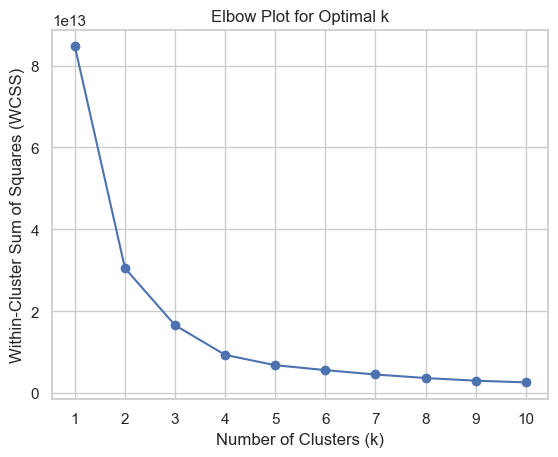

In [19]:
wcss = []

# Define the range of k values to try
k_values = range(1, 11)
numeric_columns = gdf.select_dtypes(include=['int', 'float']).columns

# Compute WCSS for each value of k
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(gdf[numeric_columns].values)
    wcss.append(km.inertia_)

# Plot the elbow plot
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Plot for Optimal k')
plt.xticks(k_values)
plt.show()

C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


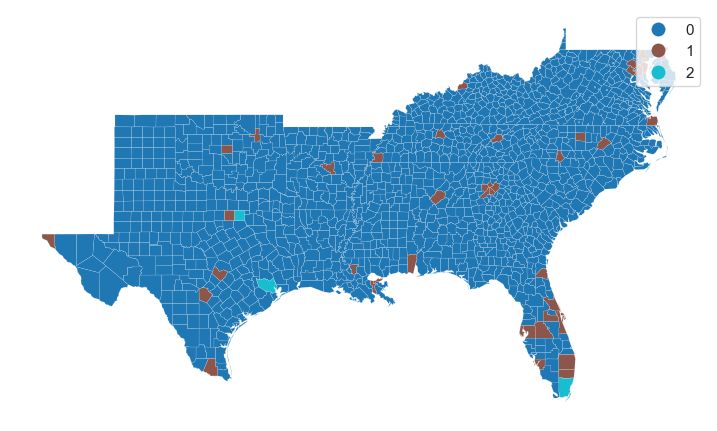

In [20]:
km5 = cluster.KMeans(n_clusters=3)
cols_90 = [col + '90' for col in ['HR', 'HC', 'PO', 'RD', 'PS', 'UE', 'DV', 'MA', 'POL', 'DNL', 'MFIL', 'FP', 'BLK', 'GI', 'FH']]
km5cls = km5.fit(gdf[cols_90].values)


f, ax = plt.subplots(1, figsize=(9, 9))

gdf.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

In [21]:

cols_60 = [col + '60' for col in ['HR', 'HC', 'PO', 'RD', 'PS', 'UE', 'DV', 'MA', 'POL', 'DNL', 'MFIL', 'FP', 'BLK', 'GI', 'FH']]
km60 = km5.fit(gdf[cols_60].values)
cols_decade = [col + '60' for col in ['HR', 'PO', 'UE',  'MA', 'FP', 'BLK', 'FH']]

# Initialize an empty dictionary to store the means of each column for each cluster
cluster_means = {}

# Iterate over each cluster
for cluster_label in range(km5.n_clusters):
    cluster_data = gdf[km60.labels_ == cluster_label]
    
    # Calculate the mean of each column for the current cluster
    cluster_mean = cluster_data[cols_decade].mean()
    
    cluster_means[f'Cluster {cluster_label}'] = cluster_mean
cluster_means_df = pd.DataFrame(cluster_means)


print("Mean values of each column for each cluster:")
print(cluster_means_df)

cluster_counts = {}

for cluster_label in range(km5.n_clusters):
    cluster_counts[f'Cluster {cluster_label}'] = (km60.labels_ == cluster_label).sum()


cluster_counts_df = pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['Number of Counties'])


print("Number of counties in each cluster:")
print(cluster_counts_df)

Mean values of each column for each cluster:
          Cluster 0      Cluster 1      Cluster 2
HR60       7.242710       9.105387       8.052404
PO60   23900.494792  727569.571429  234534.703704
UE60       5.312292       5.101418       4.579630
MA60      27.820796      28.596429      27.070370
FP60      46.376877      21.201844      24.428872
BLK60     20.008765      24.296145      18.722938
FH60      13.259460      15.032906      12.983662
Number of counties in each cluster:
           Number of Counties
Cluster 0                1344
Cluster 1                  14
Cluster 2                  54


C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


### the code has been repeated, for analysis and understand purposes and clarity in view

In [22]:

cols_70 = [col + '70' for col in ['HR', 'HC', 'PO', 'RD', 'PS', 'UE', 'DV', 'MA', 'POL', 'DNL', 'MFIL', 'FP', 'BLK', 'GI', 'FH']]
km70 = km5.fit(gdf[cols_70].values)
cols_decade = [col + '70' for col in ['HR', 'PO', 'UE',  'MA', 'FP', 'BLK', 'FH']]

cluster_means = {}

for cluster_label in range(km5.n_clusters):
    cluster_data = gdf[km70.labels_ == cluster_label]
    
    cluster_mean = cluster_data[cols_decade].mean()
    
    cluster_means[f'Cluster {cluster_label}'] = cluster_mean

cluster_means_df = pd.DataFrame(cluster_means)

print("Mean values of each column for each cluster:")
print(cluster_means_df)

cluster_counts = {}

for cluster_label in range(km5.n_clusters):
    cluster_counts[f'Cluster {cluster_label}'] = (km70.labels_ == cluster_label).sum()

cluster_counts_df = pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['Number of Counties'])

print("Number of counties in each cluster:")
print(cluster_counts_df)

Mean values of each column for each cluster:
          Cluster 0      Cluster 1     Cluster 2
HR70      10.301447      13.370352  1.928934e+01
PO70   29775.606987  501825.628571  1.445800e+06
UE70       4.406047       3.626643  3.200000e+00
MA70      29.399418      27.920714  2.883333e+01
FP70      23.704941      10.868987  9.433333e+00
BLK70     18.214242      19.359896  1.723340e+01
FH70      10.783788      12.377619  1.140000e+01
Number of counties in each cluster:
           Number of Counties
Cluster 0                1374
Cluster 1                  35
Cluster 2                   3


C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [23]:

cols_80 = [col + '80' for col in ['HR', 'HC', 'PO', 'RD', 'PS', 'UE', 'DV', 'MA', 'POL', 'DNL', 'MFIL', 'FP', 'BLK', 'GI', 'FH']]
km80 = km5.fit(gdf[cols_80].values)
cols_decade = [col + '80' for col in ['HR', 'PO', 'UE',  'MA', 'FP', 'BLK', 'FH']]
cluster_means = {}

for cluster_label in range(km5.n_clusters):
    cluster_data = gdf[km80.labels_ == cluster_label]
    
    cluster_mean = cluster_data[cols_decade].mean()
    
    cluster_means[f'Cluster {cluster_label}'] = cluster_mean

cluster_means_df = pd.DataFrame(cluster_means)

print("Mean values of each column for each cluster:")
print(cluster_means_df)

cluster_counts = {}

for cluster_label in range(km5.n_clusters):
    cluster_counts[f'Cluster {cluster_label}'] = (km80.labels_ == cluster_label).sum()

cluster_counts_df = pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['Number of Counties'])

print("Number of counties in each cluster:")
print(cluster_counts_df)

Mean values of each column for each cluster:
          Cluster 0      Cluster 1     Cluster 2
HR80      10.038372      14.370330  2.864046e+01
PO80   35588.065646  552352.789474  1.863906e+06
UE80       6.616264       5.236270  3.764431e+00
MA80      30.829626      30.171053  3.023333e+01
FP80      15.602894       9.940785  9.280074e+00
BLK80     16.839620      21.774171  1.846105e+01
FH80      12.204800      16.827607  1.539576e+01
Number of counties in each cluster:
           Number of Counties
Cluster 0                1371
Cluster 1                  38
Cluster 2                   3


C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [24]:

cols_90 = [col + '90' for col in ['HR', 'HC', 'PO', 'RD', 'PS', 'UE', 'DV', 'MA', 'POL', 'DNL', 'MFIL', 'FP', 'BLK', 'GI', 'FH']]
km90 = km5.fit(gdf[cols_90].values)
cols_decade = [col + '90' for col in ['HR', 'PO', 'UE',  'MA', 'FP', 'BLK', 'FH']]

cluster_means = {}

for cluster_label in range(km5.n_clusters):
    cluster_data = gdf[km90.labels_ == cluster_label]
    
    cluster_mean = cluster_data[cols_decade].mean()
    
    cluster_means[f'Cluster {cluster_label}'] = cluster_mean

cluster_means_df = pd.DataFrame(cluster_means)

print("Mean values of each column for each cluster:")
print(cluster_means_df)

cluster_counts = {}

for cluster_label in range(km5.n_clusters):
    cluster_counts[f'Cluster {cluster_label}'] = (km90.labels_ == cluster_label).sum()

cluster_counts_df = pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['Number of Counties'])

print("Number of counties in each cluster:")
print(cluster_counts_df)

Mean values of each column for each cluster:
          Cluster 0      Cluster 1     Cluster 2
HR90       9.337965      15.298758  2.336507e+01
PO90   38581.904832  607789.418605  2.202701e+06
UE90       7.271232       6.011245  6.971552e+00
MA90      34.074719      33.029651  3.170000e+01
FP90      16.307247      10.259115  1.235038e+01
BLK90     16.481242      21.578134  1.989895e+01
FH90      15.045318      18.754897  1.912826e+01
Number of counties in each cluster:
           Number of Counties
Cluster 0                1366
Cluster 1                  43
Cluster 2                   3


C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\anany\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

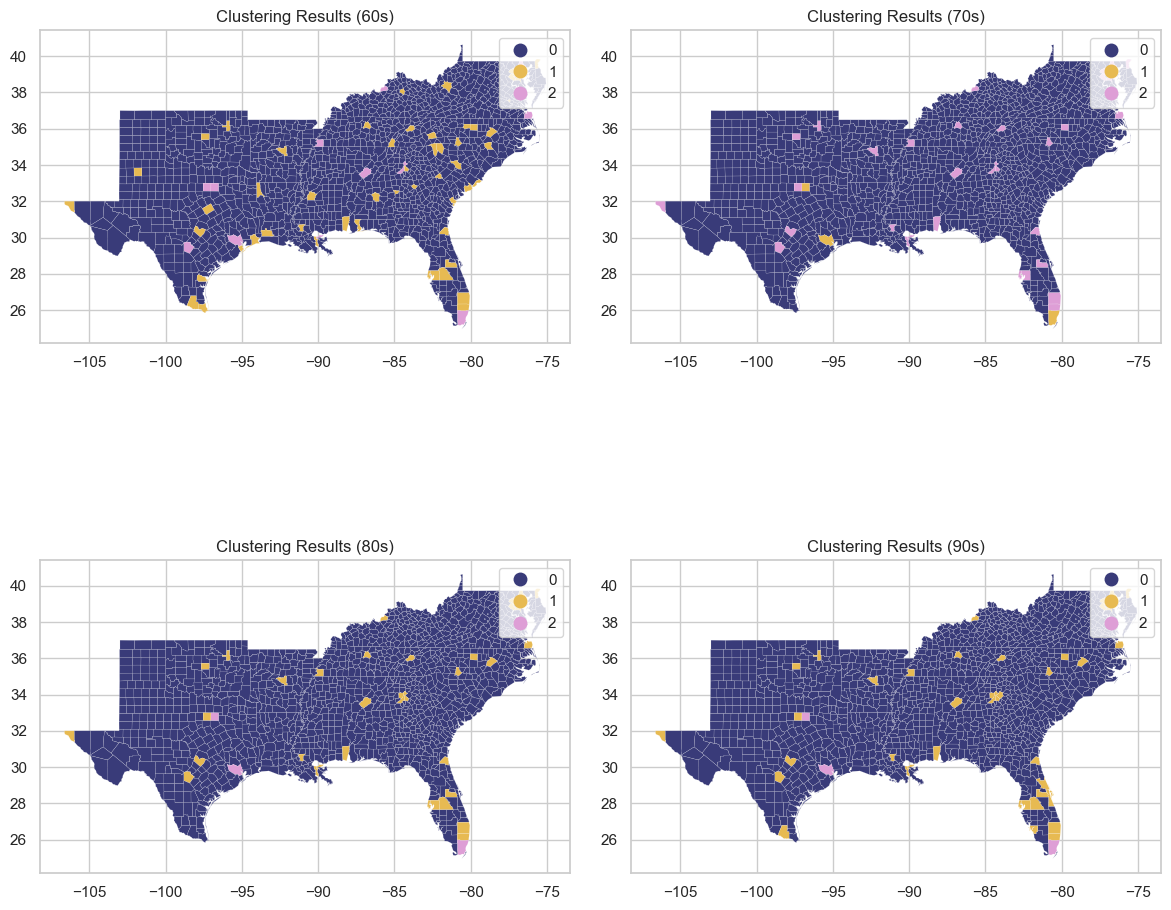

In [26]:
import matplotlib.pyplot as plt

decades = ['60', '70', '80', '90']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, decade in enumerate(decades):
    cols_decade = [col + decade for col in ['HR', 'HC', 'PO', 'RD', 'PS', 'UE', 'DV', 'MA', 'POL', 'DNL', 'MFIL', 'FP', 'BLK', 'GI', 'FH']]
    subset_df = gdf[cols_decade]
    
    km5 = KMeans(n_clusters=3, random_state=42)
    km5cls = km5.fit(subset_df.values)
    
    gdf[f'cl_{decade}'] = km5cls.labels_
    
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    gdf.plot(column=f'cl_{decade}', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax,cmap='tab20b')
    ax.set_title(f'Clustering Results ({decade}s)')

plt.tight_layout()
plt.show()